In [1]:
import sys
import pandas as pd
import time as time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from matplotlib.lines import Line2D
import time
import numba
import datetime
from scipy.optimize import curve_fit
import scienceplots
plt.style.use('science')

# Load data

In [2]:
run_path = 'processed_data/long_run_4mbar_500V/r49/'

In [3]:
# Main detectors
dssd = pd.read_csv(run_path + 'dssd_non_vetoed_events.csv') # non-vetoed, calibrated dssd events 
ppac = pd.read_csv(run_path + 'ppac_events.csv') # raw, uncalibrated
ruth = pd.read_csv(run_path + 'rutherford_events.csv')

# DSSD regions
imp = dssd[dssd['event_type'] == 'imp']
boxE = dssd[dssd['event_type'] == 'boxE']
boxW = dssd[dssd['event_type'] == 'boxW']
boxT = dssd[dssd['event_type'] == 'boxT']
boxB = dssd[dssd['event_type'] == 'boxB']

# PPAC 
cathode = ppac[ppac['detector'] == 'cathode']
anodeV = ppac[ppac['detector'] == 'anodeV']
anodeH = ppac[ppac['detector'] == 'anodeH']

# Rutherfords
ruth_E = ruth[ruth['detector'] == 'ruthE']
ruth_W = ruth[ruth['detector'] == 'ruthW']
ruth_E_cut = ruth_E[ruth_E['energy'] > 8000]

(0.0, 2000.0)

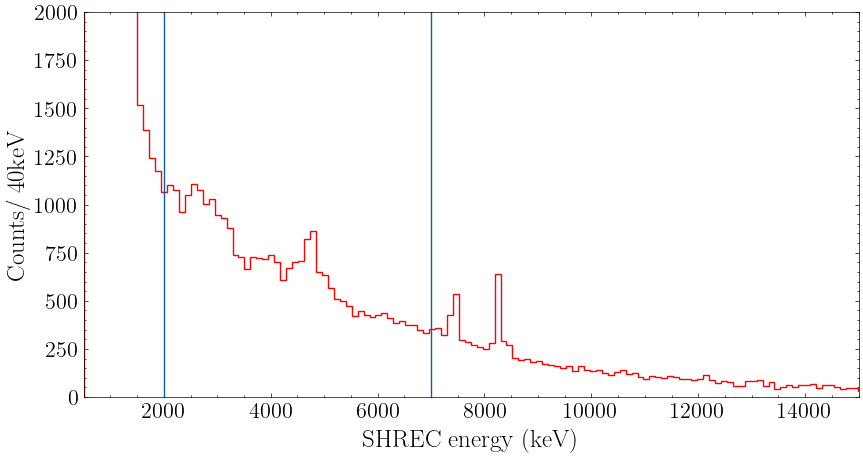

In [4]:
# Look at raw implant stuff
plt.figure(figsize=(10,5))
fs=18
plt.hist(imp['xE'], histtype='step',bins=175, range=(500,20000), color='r')
plt.xlabel('SHREC energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 40keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.axvline(x=2000)
plt.axvline(x=7000)
ax.set_xlim(500,15000)
ax.set_ylim(0,2000)
# ax.set_yscale('log')

# PPAC-SHREC coincidences

In [5]:
# Coincidence window
window_before_ns = 5000  # 1700 ns (1.7 us) before
window_after_ns = 2000   # 1000 ns (1 us) after

# Convert to picoseconds for use with timetag values
window_before_ps = window_before_ns * 1000  # ns to ps
window_after_ps = window_after_ns * 1000    # ns to ps

In [6]:
# Sort dfs by time (should already be sorted)
cathode_sorted = cathode.sort_values('timetag').reset_index(drop=True)
anodeV_sorted = anodeV.sort_values('timetag').reset_index(drop=True)
anodeH_sorted = anodeH.sort_values('timetag').reset_index(drop=True)
imp_sorted = imp.sort_values('tagx').reset_index(drop=True)  # Using tagx for IMP

In [7]:
# Grab timetag vals (faster searching)
cathode_timetags = cathode_sorted['timetag'].values
anodeV_timetags = anodeV_sorted['timetag'].values
anodeH_timetags = anodeH_sorted['timetag'].values
imp_timetags = imp_sorted['tagx'].values  # Using tagx as the IMP timetag

In [8]:
# Function to find PPAC events within the time window
def find_events_in_window(imp_timetag, detector_timetags, window_before_ps, window_after_ps):
    
    # Calculate the time bounds
    lower_bound = imp_timetag - window_before_ps  # Time window before IMP
    upper_bound = imp_timetag + window_after_ps   # Time window after IMP
    
    # Find all events within these bounds using binary search 
    lower_idx = np.searchsorted(detector_timetags, lower_bound)
    upper_idx = np.searchsorted(detector_timetags, upper_bound)
    
    if upper_idx > lower_idx:
        return list(range(lower_idx, upper_idx))
    return []

# Start timing the search
start_time = time.time()

# Create list to store coincident events
coincident_events = []
non_ppac_coincident_events = []

# Number of IMP events to process
total_imp_events = len(imp_sorted)
print(f"Processing {total_imp_events} IMP events...")

    
# Counter for plate hits
all_three = 0
any_two = 0
exactly_one = 0
no_ppac = 0

# For each IMP event, find coincident PPAC signals
for idx, imp_row in imp_sorted.iterrows():
    imp_timetag = imp_row['tagx'] # remember we are using tagx for the timetag here
    
    # Find ppac events in time window
    cathode_indices = find_events_in_window(imp_timetag, cathode_timetags, window_before_ps, window_after_ps)
    anodeV_indices = find_events_in_window(imp_timetag, anodeV_timetags, window_before_ps, window_after_ps)
    anodeH_indices = find_events_in_window(imp_timetag, anodeH_timetags, window_before_ps, window_after_ps)
    
    # Count coincidence patterns
    has_cathode = len(cathode_indices) > 0
    has_anodeV = len(anodeV_indices) > 0
    has_anodeH = len(anodeH_indices) > 0
    
    # Count how many PPAC signals are present
    signal_count = has_cathode + has_anodeV + has_anodeH
    
    # Categorize based on count
    if signal_count == 3:
        all_three += 1
    elif signal_count == 2:
        any_two += 1
    elif signal_count == 1:
        exactly_one += 1
    else:
        no_ppac += 1

    
    # This is the ppac or condition...
#     if cathode_indices or anodeV_indices or anodeH_indices:

#         # Find the most recent (last) detected signal in any PPAC
#         last_cathode = cathode_indices[-1] if cathode_indices else None
#         last_anodeV = anodeV_indices[-1] if anodeV_indices else None
#         last_anodeH = anodeH_indices[-1] if anodeH_indices else None

#         # "Cheat" by filling in missing values using the last detected signal
#         filled_cathode = last_cathode if last_cathode is not None else (last_anodeV if last_anodeV is not None else last_anodeH)
#         filled_anodeV = last_anodeV if last_anodeV is not None else (last_cathode if last_cathode is not None else last_anodeH)
#         filled_anodeH = last_anodeH if last_anodeH is not None else (last_cathode if last_cathode is not None else last_anodeV)

#         # Ensure the filled values are valid (they might still be None)
#         cathode_data = cathode_sorted.iloc[filled_cathode] if filled_cathode is not None and filled_cathode < len(cathode_sorted) else None
#         anodeV_data = anodeV_sorted.iloc[filled_anodeV] if filled_anodeV is not None and filled_anodeV < len(anodeV_sorted) else None
#         anodeH_data = anodeH_sorted.iloc[filled_anodeH] if filled_anodeH is not None and filled_anodeH < len(anodeH_sorted) else None

#         # Ensure we have at least one valid PPAC signal before proceeding
#         if cathode_data is not None or anodeV_data is not None or anodeH_data is not None:

#             # Calculate time differences (set to NaN if missing)
#             dt_cathode_ps = cathode_data['timetag'] - imp_timetag if cathode_data is not None else np.nan
#             dt_anodeV_ps = anodeV_data['timetag'] - imp_timetag if anodeV_data is not None else np.nan
#             dt_anodeH_ps = anodeH_data['timetag'] - imp_timetag if anodeH_data is not None else np.nan

#             # Store the event
#             event_data = {
#                 'imp_timetag': imp_timetag,
#                 'cathode_timetag': cathode_data['timetag'] if cathode_data is not None else np.nan,
#                 'anodeV_timetag': anodeV_data['timetag'] if anodeV_data is not None else np.nan,
#                 'anodeH_timetag': anodeH_data['timetag'] if anodeH_data is not None else np.nan,
#                 'dt_cathode_ps': dt_cathode_ps,
#                 'dt_anodeV_ps': dt_anodeV_ps,
#                 'dt_anodeH_ps': dt_anodeH_ps,
#                 'dt_cathode_ns': dt_cathode_ps / 1000,
#                 'dt_anodeV_ns': dt_anodeV_ps / 1000,
#                 'dt_anodeH_ns': dt_anodeH_ps / 1000,
#                 # IMP data
#                 'imp_timetag': imp_timetag,
#                 'imp_x': imp_row['x'],
#                 'imp_y': imp_row['y'],
#                 'imp_tagx': imp_row['tagx'],
#                 'imp_tagy': imp_row['tagy'],
#                 'imp_nfile': imp_row['nfile'],
#                 'imp_tdelta': imp_row['tdelta'],
#                 'imp_nX': imp_row['nX'],
#                 'imp_nY': imp_row['nY'],
#                 'imp_xE': imp_row['xE'],
#                 'imp_yE': imp_row['yE'],
#                 'xboard': imp_row['xboard'],
#                 'yboard': imp_row['yboard'],
#             }

#             coincident_events.append(event_data)

    
    # Only proceed if we have coincidences in all three PPAC detectors - AND condition here
    if cathode_indices and anodeV_indices and anodeH_indices:
        
        # Find the closest event in each detector (smallest absolute time difference)
        cathode_diffs = np.abs(cathode_timetags[cathode_indices] - imp_timetag)
        anodeV_diffs = np.abs(anodeV_timetags[anodeV_indices] - imp_timetag)
        anodeH_diffs = np.abs(anodeH_timetags[anodeH_indices] - imp_timetag)
        
        closest_cathode_idx = cathode_indices[np.argmin(cathode_diffs)]
        closest_anodeV_idx = anodeV_indices[np.argmin(anodeV_diffs)]
        closest_anodeH_idx = anodeH_indices[np.argmin(anodeH_diffs)]
        
        # Get the corresponding rows
        cathode_data = cathode_sorted.iloc[closest_cathode_idx]
        anodeV_data = anodeV_sorted.iloc[closest_anodeV_idx]
        anodeH_data = anodeH_sorted.iloc[closest_anodeH_idx]
        
        # Calculate time difference values (in picoseconds)
        # +ve = PPAC after IMP, -ve = PPAC before IMP
        dt_cathode_ps = cathode_data['timetag'] - imp_timetag
        dt_anodeV_ps = anodeV_data['timetag'] - imp_timetag
        dt_anodeH_ps = anodeH_data['timetag'] - imp_timetag
        
        # Create event data dictionary with all relevant information
        event_data = {
            # IMP data
            'imp_timetag': imp_timetag,
            'imp_x': imp_row['x'],
            'imp_y': imp_row['y'],
            'imp_tagx': imp_row['tagx'],
            'imp_tagy': imp_row['tagy'],
            'imp_nfile': imp_row['nfile'],
            'imp_tdelta': imp_row['tdelta'],
            'imp_nX': imp_row['nX'],
            'imp_nY': imp_row['nY'],
            'imp_xE': imp_row['xE'],
            'imp_yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
            
            # Cathode data
            'cathode_timetag': cathode_data['timetag'],
            'cathode_energy': cathode_data['energy'],
            'cathode_board': cathode_data['board'],
            'cathode_channel': cathode_data['channel'],
            'cathode_nfile': cathode_data['nfile'],
            
            # AnodeV data
            'anodeV_timetag': anodeV_data['timetag'],
            'anodeV_energy': anodeV_data['energy'],
            'anodeV_board': anodeV_data['board'],
            'anodeV_channel': anodeV_data['channel'],
            'anodeV_nfile': anodeV_data['nfile'],
            
            # AnodeH data
            'anodeH_timetag': anodeH_data['timetag'],
            'anodeH_energy': anodeH_data['energy'],
            'anodeH_board': anodeH_data['board'],
            'anodeH_channel': anodeH_data['channel'],
            'anodeH_nfile': anodeH_data['nfile'],
            
            # Time difference values (in picoseconds)
            'dt_cathode_ps': dt_cathode_ps,
            'dt_anodeV_ps': dt_anodeV_ps,
            'dt_anodeH_ps': dt_anodeH_ps,
            
            # Convert to nanoseconds for convenience
            'dt_cathode_ns': dt_cathode_ps / 1000,
            'dt_anodeV_ns': dt_anodeV_ps / 1000,
            'dt_anodeH_ns': dt_anodeH_ps / 1000
        }
        
        coincident_events.append(event_data)
        
    # IMportant not OR condition. Data is not separated into just all three, and not any - so theres a tiny percentage not included.    
    if not (cathode_indices or anodeV_indices or anodeH_indices):
        non_coincident_data = {
            # IMP data
            'timetag': imp_timetag,
            't':imp_timetag / 1e12,
            'x': imp_row['x'],
            'y': imp_row['y'],
            'tagx': imp_row['tagx'],
            'tagy': imp_row['tagy'],
            'nfile': imp_row['nfile'],
            'tdelta': imp_row['tdelta'],
            'nX': imp_row['nX'],
            'nY': imp_row['nY'],
            'xE': imp_row['xE'],
            'yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
        }
        
        non_ppac_coincident_events.append(non_coincident_data)
    
    # Print progress every 10,000 events
    if idx % 10000 == 0 and idx > 0:
        elapsed = time.time() - start_time
        events_per_sec = idx / elapsed
        remaining_time = (total_imp_events - idx) / events_per_sec if events_per_sec > 0 else 0
        print(f"Processed {idx}/{total_imp_events} events ({idx/total_imp_events*100:.1f}%) - Rate: {events_per_sec:.1f} events/sec - ETA: {remaining_time:.1f} sec")

# Create the df with coincident events
coincident_imp_df = pd.DataFrame(coincident_events)
non_coincident_imp_df = pd.DataFrame(non_ppac_coincident_events)
print(f"Found {len(coincident_imp_df)} coincidences within the window")

# Calculate total processing time
elapsed_time = time.time() - start_time
print(f"Total processing time: {elapsed_time:.2f} seconds")
print(f"Processing rate: {total_imp_events/elapsed_time:.1f} events/second")

total_imp = len(imp_sorted)  # Total number of implant events
any_one = all_three + any_two + exactly_one  # Events with at least one signal

print(f"Stats:")
print(f"All three PPAC signals: {all_three} ({all_three/total_imp*100:.1f}%)")
print(f"Exactly two PPAC signals: {any_two} ({any_two/total_imp*100:.1f}%)")
print(f"Exactly one PPAC signal: {exactly_one} ({exactly_one/total_imp*100:.1f}%)")
print(f"At least one PPAC signal: {any_one} ({any_one/total_imp*100:.1f}%)")
print(f"No PPAC signals: {no_ppac} ({no_ppac/total_imp*100:.1f}%)")



Processing 737518 IMP events...
Processed 10000/737518 events (1.4%) - Rate: 9347.8 events/sec - ETA: 77.8 sec
Processed 20000/737518 events (2.7%) - Rate: 10332.7 events/sec - ETA: 69.4 sec
Processed 30000/737518 events (4.1%) - Rate: 10769.0 events/sec - ETA: 65.7 sec
Processed 40000/737518 events (5.4%) - Rate: 11046.4 events/sec - ETA: 63.1 sec
Processed 50000/737518 events (6.8%) - Rate: 11217.7 events/sec - ETA: 61.3 sec
Processed 60000/737518 events (8.1%) - Rate: 11304.5 events/sec - ETA: 59.9 sec
Processed 70000/737518 events (9.5%) - Rate: 11388.3 events/sec - ETA: 58.6 sec
Processed 80000/737518 events (10.8%) - Rate: 11437.1 events/sec - ETA: 57.5 sec
Processed 90000/737518 events (12.2%) - Rate: 11477.4 events/sec - ETA: 56.4 sec
Processed 100000/737518 events (13.6%) - Rate: 11508.8 events/sec - ETA: 55.4 sec
Processed 110000/737518 events (14.9%) - Rate: 11533.3 events/sec - ETA: 54.4 sec
Processed 120000/737518 events (16.3%) - Rate: 11564.1 events/sec - ETA: 53.4 sec
P

# Plot raw etof

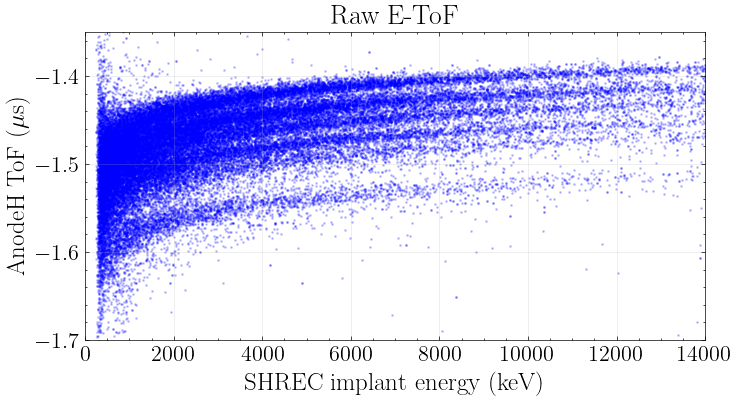

In [9]:
if not coincident_imp_df.empty:
    # Convert ns time differences to us for plotting
    coincident_imp_df['dt_cathode_us'] = coincident_imp_df['dt_cathode_ns'] / 1000  # ns to μs
    coincident_imp_df['dt_anodeV_us'] = coincident_imp_df['dt_anodeV_ns'] / 1000    # ns to μs
    coincident_imp_df['dt_anodeH_us'] = coincident_imp_df['dt_anodeH_ns'] / 1000    # ns to μs
    
    plt.figure(figsize=(8, 4))
    fs = 18
    plt.scatter(coincident_imp_df['imp_xE'], coincident_imp_df['dt_anodeH_us'], 
                alpha=0.2, s=1, c='blue')
    plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
    plt.ylabel(r"AnodeH ToF ($\mu$s)", fontsize=fs)
    plt.title("Raw E-ToF", fontsize=fs+2)
    plt.xlim(0, 14000)
    plt.ylim(-1.7, -1.35)
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=fs-2)
#     plt.legend(fontsize=fs-4, frameon=True)
    plt.savefig("plots/raw_etof.pdf", dpi=1000)
else:
    print("No coincidences")

# Time correction for SHREC imp region boards

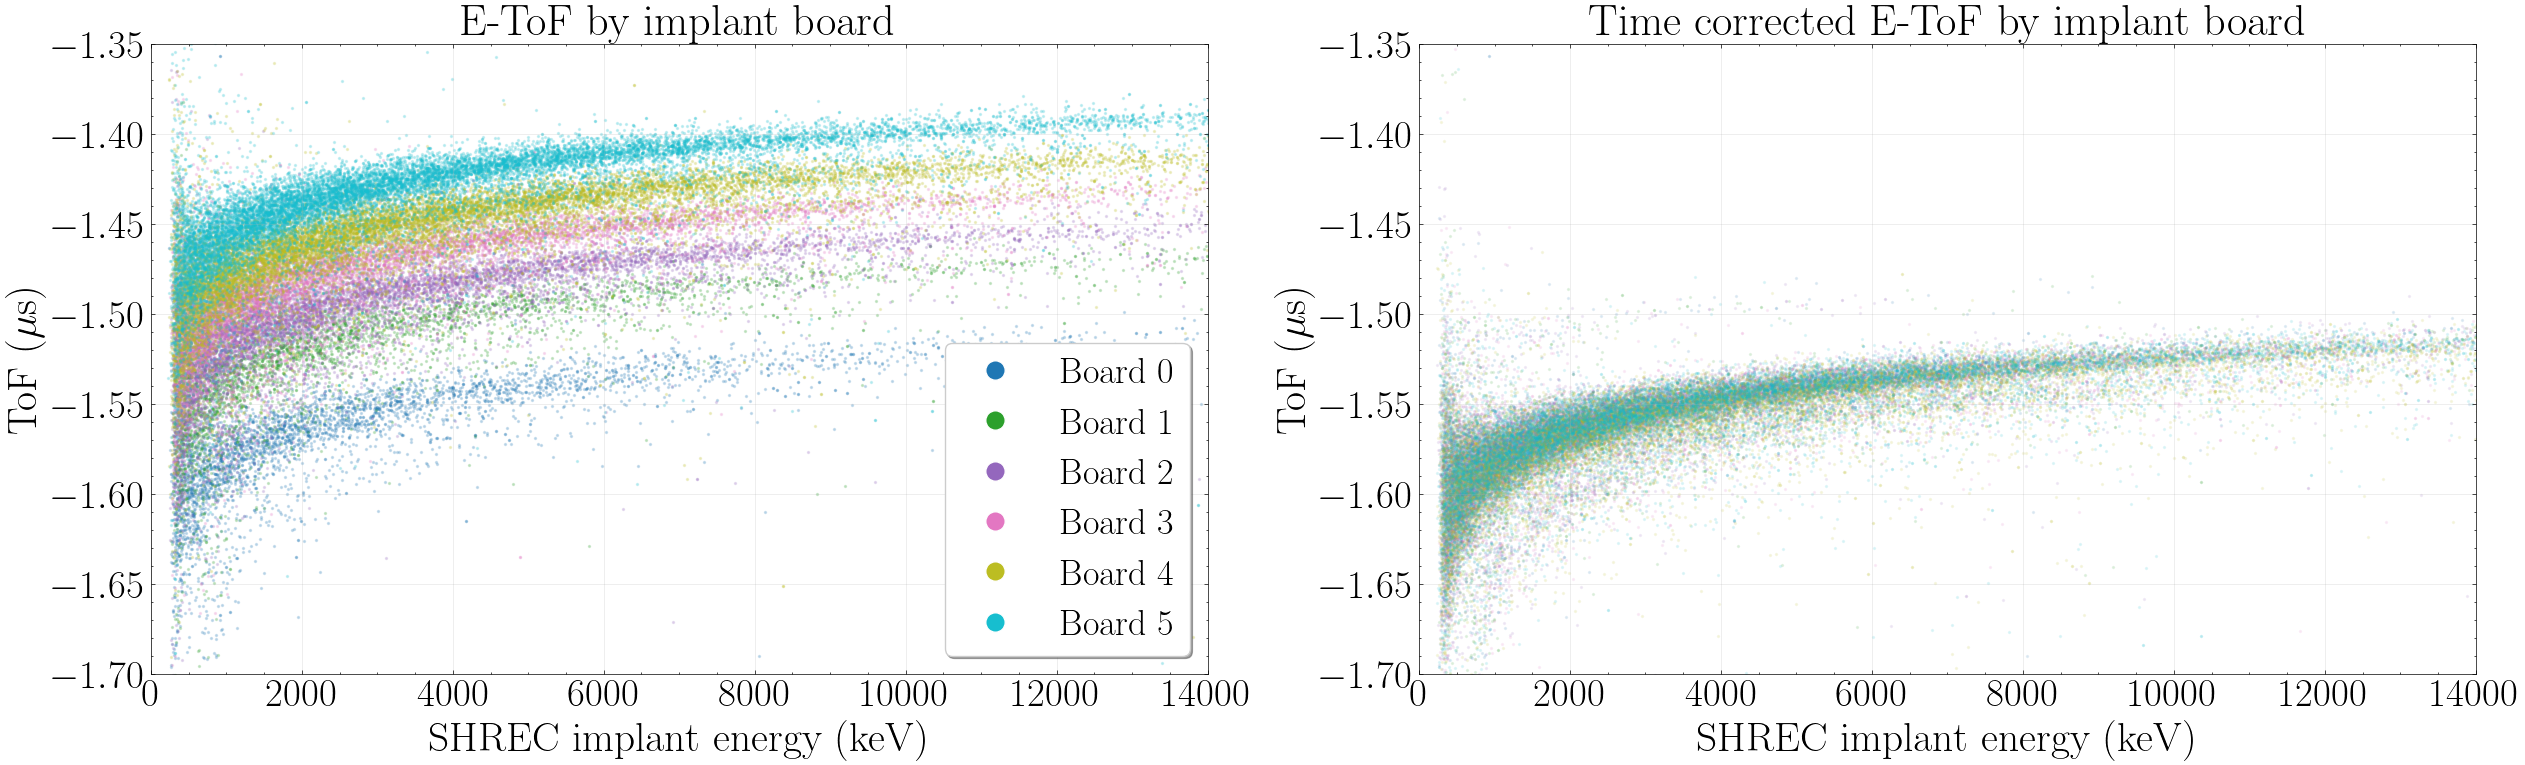

In [10]:
# Get the recoil time in seconds
coincident_imp_df['t'] = coincident_imp_df['imp_timetag'] * 1e-12

# Define manual time offsets for the boards- board0 is master
manual_offsets = {
    0: 0,
    1: -0.045e-6,
    2: -0.065e-6,
    3: -0.085e-6,
    4: -0.105e-6,
    5: -0.125e-6,
}

# Calculate the corrected dt for the ppac plates in microseconds
# Staying consistent with xboard
coincident_imp_df['dt_anodeH_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_anodeH_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp_df['dt_anodeV_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_anodeV_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp_df['dt_cathode_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_cathode_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

# Get boards
boards = sorted(coincident_imp_df['xboard'].unique())

plt.figure(figsize=(30,18))
fs=30

plt.subplot(221)
colors = plt.cm.tab10(np.linspace(0, 1, len(boards)))
legend_handles = []

for board, color in zip(boards, colors):
    # Filter the df for this board
    board_data = coincident_imp_df[coincident_imp_df['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us'],
                s=2, alpha=0.2, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True, shadow=True, facecolor='white')

plt.subplot(222)
for board, color in zip(boards, colors):
    # Filter the DataFrame for this board
    board_data = coincident_imp_df[coincident_imp_df['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us_corr'],
                s=2, alpha=0.1, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("Time corrected E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True)


plt.savefig("plots/etof_by_board.png", dpi=1000)


# Decay events

In [11]:
# Set decay time window
min_corr_time = 0.00000001     # Minimum time after recoil to consider (in seconds)
max_corr_time = 1.53 * 10     # Maximum time after recoil to consider (in seconds)

In [12]:
# Build pixel history from the imp df & group the full implant event history by pixel (x,y)
pixel_groups = imp.groupby(['x', 'y'])
pixel_history = {pixel: group for pixel, group in pixel_groups}

In [13]:
# Create decay event list
decay_events = []

In [14]:
# For each recoil event, search for subsequent events in the same pixel from imp

# Create decay events list to hold events
decay_candidates = []  

# Loop through coincident imp (recoil-like) events
for recoil_idx, recoil in coincident_imp_df.iterrows():
    
    # Get the pixel for the recoil event
    pixel = (recoil['imp_x'], recoil['imp_y'])
    
    # Convert the recoil imp_timetag from picoseconds to seconds
    recoil_time_sec = recoil['imp_timetag'] / 1e12
    
    # Check if there are any events in the same pixel in the imp region df.
    if pixel not in pixel_history:
        continue  # Skip if no events are found for this pixel
    
    # Get the time sorted events for this pixel from imp
    pixel_df = pixel_history[pixel]
    
    # Get the pixel time values as a sorted array
    time_array = pixel_df['t'].values # This is in seconds
    
    # Define the lower and upper bounds for candidate decay events in seconds
    lower_bound = recoil_time_sec + min_corr_time
    upper_bound = recoil_time_sec + max_corr_time
    
    # Use binary search to find the index positions in the time array
    start_idx = np.searchsorted(time_array, lower_bound, side='left')
    end_idx = np.searchsorted(time_array, upper_bound, side='right')
    
    # If events exist in the correlation window, add them as candidate decay events
    if start_idx < end_idx:
        
        candidate_events = pixel_df.iloc[start_idx:end_idx].copy()
        
        # Record the associated recoil info for later
        candidate_events['recoil_index'] = recoil_idx 
        candidate_events['recoil_time_sec'] = recoil_time_sec
        decay_candidates.append(candidate_events) # add decay candidates to list

# Combine all candidate decay events into a single df
if decay_candidates:
    decay_candidates_df = pd.concat(decay_candidates, ignore_index=True)
else:
    decay_candidates_df = pd.DataFrame()

# Display the first few decay candidates
print(decay_candidates_df.head())


           t    x   y            tagx            tagy  nfile  xboard  yboard  \
0   0.400866   39  50    400865502745    400865446996      0       4       7   
1   0.573818  118  15    573817930247    573817837118      0       1       6   
2   1.067900   70   5   1067899768495   1067899744007      0       3       6   
3  12.745654  116  38  12745654242999  12745654131995      0       1       7   
4  16.457094   51  16  16457094180996  16457094035992      0       4       7   

   tdelta  nX  nY           xE           yE event_type  recoil_index  \
0   55749   1   1  1059.421343  1021.612576        imp             1   
1   93129   1   1  1461.149044  1487.609336        imp             2   
2   24488   1   1   694.938142   699.535776        imp             3   
3  111004   1   1   464.951573   456.632179        imp             4   
4  145004   1   1   349.606590   349.284471        imp             6   

   recoil_time_sec  
0         0.400866  
1         0.573818  
2         1.067900  
3 

# PPAC Anticoincidence check for decays

Check the candidate decay is in the non-coincident list, do this by merging on pixel?
Should already be pretty strict at this point, but check anyways.

In [15]:
# Check the unique (x, y, t) 
print("Decay candidates:", decay_candidates_df[['x', 'y', 't']].drop_duplicates().shape)
print("Non-coincident:", non_coincident_imp_df[['x', 'y', 't']].drop_duplicates().shape)

Decay candidates: (45443, 3)
Non-coincident: (660362, 3)


In [16]:
if not decay_candidates_df.empty:
    # Drop duplicate rows based on x and y in non_coincident_imp_df
    non_coincident_clean = non_coincident_imp_df[['x', 'y']].drop_duplicates()
    
    # every row in decay_candidates_df is kept, 
    # and we add data from non_coincident_clean where there is a match on x and y
    decay_candidates_df = decay_candidates_df.merge(
        non_coincident_clean, 
        on=['x', 'y'],
        how='left',
        indicator='ppac_flag'
    )
    
    # If an event from decay_candidates_df finds a matching row in non_coincident_clean, 
    # ppac_flag will be set to "both".
    # If there is no match (i.e. PPAC signal), ppac_flag will be 'left_only'
    decay_candidates_df['is_clean'] = decay_candidates_df['ppac_flag'] == 'both'

print(decay_candidates_df['is_clean'].value_counts())
print(decay_candidates_df.head())


is_clean
True    45904
Name: count, dtype: int64
           t    x   y            tagx            tagy  nfile  xboard  yboard  \
0   0.400866   39  50    400865502745    400865446996      0       4       7   
1   0.573818  118  15    573817930247    573817837118      0       1       6   
2   1.067900   70   5   1067899768495   1067899744007      0       3       6   
3  12.745654  116  38  12745654242999  12745654131995      0       1       7   
4  16.457094   51  16  16457094180996  16457094035992      0       4       7   

   tdelta  nX  nY           xE           yE event_type  recoil_index  \
0   55749   1   1  1059.421343  1021.612576        imp             1   
1   93129   1   1  1461.149044  1487.609336        imp             2   
2   24488   1   1   694.938142   699.535776        imp             3   
3  111004   1   1   464.951573   456.632179        imp             4   
4  145004   1   1   349.606590   349.284471        imp             6   

   recoil_time_sec ppac_flag  is_clea

# Decay KHS

In [17]:
# Find the log time between implant and decay event
decay_candidates_df['log_dt'] = np.log(abs(decay_candidates_df['t'] - decay_candidates_df['recoil_time_sec']))

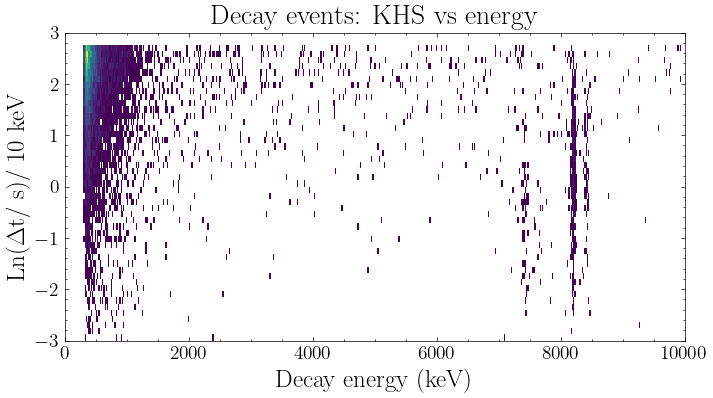

In [18]:
# Plot the 2d KHS hist
fs = 18
plt.figure(figsize=(8,4))
plt.hist2d(decay_candidates_df['yE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((0,10000),(-3,3)), cmin=1)
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.savefig('plots/decay_khs.pdf', dpi=1000)

# EVR-a correlations

In [19]:
# Alpha energy, time gates
# Recoil energy gates

alpha_energy_min = 8170    # Minimum alpha energy (keV)
alpha_energy_max = 8300    # Maximum alpha energy (keV)

recoil_energy_min = 1000   # Minimum recoil energy (keV)
recoil_energy_max = 8100  # Maximum recoil energy (keV) 

alpha_corr_min = 0.000000001    # Minimum time difference in seconds 
alpha_corr_max = 1.53 * 10       # Maximum time difference in seconds


In [20]:
# Filter alpha candidates by energy
filtered_alpha_candidates = decay_candidates_df[
    (decay_candidates_df['xE'] >= alpha_energy_min) & 
    (decay_candidates_df['xE'] <= alpha_energy_max)
].copy()


In [21]:
# just making sure we have t
if 't' not in filtered_alpha_candidates.columns:
    filtered_alpha_candidates['t'] = filtered_alpha_candidates['timetag'] / 1e12 

##  Correlations - Single strategy

In [22]:

# # for each alpha candidate, find the preceeding recoil in same pixel

# # initialising cols in the df
# filtered_alpha_candidates['closest_recoil_index'] = np.nan
# filtered_alpha_candidates['recoil_time'] = np.nan
# filtered_alpha_candidates['time_difference'] = np.nan
# filtered_alpha_candidates['recoil_energy'] = np.nan

# # loop through the alpha candidates
# for idx, alpha in filtered_alpha_candidates.iterrows():
#     pixel_x = alpha['x']
#     pixel_y = alpha['y']
#     alpha_time = alpha['t']
    
#     # Retrieve all recoil events from the same pixel
#     recoils_in_pixel = coincident_imp_df[
#         (coincident_imp_df['imp_x'] == pixel_x) & (coincident_imp_df['imp_y'] == pixel_y)
#     ]
    
#     # apply recoil energy gate
#     recoils_in_pixel = recoils_in_pixel[
#         (recoils_in_pixel['imp_xE'] >= recoil_energy_min) &
#         (recoils_in_pixel['imp_xE'] <= recoil_energy_max)
#     ]
    
#     # Only consider recoils that occurred before the alpha event
#     recoils_before = recoils_in_pixel[recoils_in_pixel['t'] < alpha_time]
    
#     if not recoils_before.empty:
        
#         # its good to work with copies... compute the time difference between r-a
#         recoils_before = recoils_before.copy()
#         recoils_before['time_diff'] = alpha_time - recoils_before['t']
        
#         # make sure the r-a fits in the coincidence window
#         recoils_in_window = recoils_before[
#             (recoils_before['time_diff'] >= alpha_corr_min) &
#             (recoils_before['time_diff'] <= alpha_corr_max)
#         ]
        
#         if not recoils_in_window.empty:
#             # there might be multiple correlations, so choose the one with the smallest time difference
#             closest_recoil = recoils_in_window.loc[recoils_in_window['time_diff'].idxmin()]
#             filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = closest_recoil.name
#             filtered_alpha_candidates.at[idx, 'recoil_time'] = closest_recoil['t']
#             filtered_alpha_candidates.at[idx, 'time_difference'] = closest_recoil['time_diff']
#             filtered_alpha_candidates.at[idx, 'recoil_energy'] = closest_recoil['imp_xE']
#         else:
#             filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = np.nan
#             filtered_alpha_candidates.at[idx, 'recoil_time'] = np.nan
#             filtered_alpha_candidates.at[idx, 'time_difference'] = np.nan
#             filtered_alpha_candidates.at[idx, 'recoil_energy'] = np.nan
#     else:
#         filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = np.nan
#         filtered_alpha_candidates.at[idx, 'recoil_time'] = np.nan
#         filtered_alpha_candidates.at[idx, 'time_difference'] = np.nan
#         filtered_alpha_candidates.at[idx, 'recoil_energy'] = np.nan

## Square strategy

In [23]:
# Add columns to store correlation info
filtered_alpha_candidates['closest_recoil_index'] = np.nan
filtered_alpha_candidates['recoil_time'] = np.nan
filtered_alpha_candidates['time_difference'] = np.nan
filtered_alpha_candidates['recoil_energy'] = np.nan
filtered_alpha_candidates['correlated_pixel_x'] = np.nan
filtered_alpha_candidates['correlated_pixel_y'] = np.nan
filtered_alpha_candidates['is_same_pixel'] = False

# Loop through the alpha candidates
for idx, alpha in filtered_alpha_candidates.iterrows():
    alpha_x = alpha['x']
    alpha_y = alpha['y']
    alpha_time = alpha['t']
    
    # Define all pixels to check (current pixel + 8 neighbors) - only on x so far I guess
    pixels_to_check = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            neighbor_x = alpha_x + dx
            neighbor_y = alpha_y + dy
            if (neighbor_x, neighbor_y) in pixel_history:
                pixels_to_check.append((neighbor_x, neighbor_y))
    
    # Variables to track the closest recoil
    min_time_diff = float('inf')
    best_match = None
    best_pixel = None
    
    # Check all pixels for a potential recoil
    for pixel in pixels_to_check:
        pixel_x, pixel_y = pixel
        
        # Find recoils in this pixel
        recoils_in_pixel = coincident_imp_df[
            (coincident_imp_df['imp_x'] == pixel_x) & 
            (coincident_imp_df['imp_y'] == pixel_y)
        ]
        
        # Filter for recoils before the alpha and within time and energy window
        if not recoils_in_pixel.empty:
            recoils_before = recoils_in_pixel[recoils_in_pixel['t'] < alpha_time].copy()
            
            if not recoils_before.empty:
                recoils_before['time_diff'] = alpha_time - recoils_before['t']
                
                # Apply correlation time window
                recoils_in_window = recoils_before[
                    (recoils_before['time_diff'] >= alpha_corr_min) &
                    (recoils_before['time_diff'] <= alpha_corr_max) &
                    (recoils_before['imp_xE'] >= recoil_energy_min) &
                    (recoils_before['imp_xE'] <= recoil_energy_max)
                ]
                
                if not recoils_in_window.empty:
                    # Find the closest recoil in this pixel
                    closest_idx = recoils_in_window['time_diff'].idxmin()
                    closest_recoil = recoils_in_window.loc[closest_idx]
                    
                    # If this is closer than any previously found recoil, update best match
                    if closest_recoil['time_diff'] < min_time_diff:
                        min_time_diff = closest_recoil['time_diff']
                        best_match = closest_recoil
                        best_pixel = pixel
    
    # Store the results if a correlation was found
    if best_match is not None:
        filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = best_match.name
        filtered_alpha_candidates.at[idx, 'recoil_time'] = best_match['t']
        filtered_alpha_candidates.at[idx, 'time_difference'] = min_time_diff
        filtered_alpha_candidates.at[idx, 'recoil_energy'] = best_match['imp_xE']
        filtered_alpha_candidates.at[idx, 'correlated_pixel_x'] = best_pixel[0]
        filtered_alpha_candidates.at[idx, 'correlated_pixel_y'] = best_pixel[1]
        filtered_alpha_candidates.at[idx, 'is_same_pixel'] = (best_pixel[0] == alpha_x and best_pixel[1] == alpha_y)

# Get all correlated events
correlated_events = filtered_alpha_candidates.dropna(subset=['closest_recoil_index'])

# Count same-pixel vs neighboring-pixel correlations
same_pixel_count = correlated_events['is_same_pixel'].sum()
neighbor_pixel_count = len(correlated_events) - same_pixel_count

print(f"Total correlated events: {len(correlated_events)}")
print(f"Same pixel correlations: {same_pixel_count} ({same_pixel_count/len(correlated_events)*100:.1f}%)")
print(f"Neighboring pixel correlations: {neighbor_pixel_count} ({neighbor_pixel_count/len(correlated_events)*100:.1f}%)")

# If there are neighboring-pixel correlations, look at the patterns
if neighbor_pixel_count > 0:
    neighbor_correlations = correlated_events[~correlated_events['is_same_pixel']].copy()
    
    # Calculate offsets
    neighbor_correlations['dx'] = neighbor_correlations['correlated_pixel_x'] - neighbor_correlations['x']
    neighbor_correlations['dy'] = neighbor_correlations['correlated_pixel_y'] - neighbor_correlations['y']
    
    # Count patterns
    pattern_counts = neighbor_correlations.groupby(['dx', 'dy']).size().reset_index(name='count')
    print("\nNeighboring pixel correlation patterns:")
    print(pattern_counts.sort_values('count', ascending=False))


Total correlated events: 400
Same pixel correlations: 338 (84.5%)
Neighboring pixel correlations: 62 (15.5%)

Neighboring pixel correlation patterns:
    dx   dy  count
2  0.0 -1.0     55
0 -1.0  0.0      2
1 -1.0  1.0      2
3  0.0  1.0      2
4  1.0  1.0      1


In [24]:
# Build the correlation df
correlated_events = filtered_alpha_candidates.dropna(subset=['recoil_time']).copy()
print("Number of correlated alpha-recoil events:", len(correlated_events))
print(correlated_events.head())

Number of correlated alpha-recoil events: 400
              t    x   y             tagx             tagy  nfile  xboard  \
324   74.879222   26  39   74879222067810   74879222064338      0       5   
512  134.270143   49   7  134270142781431  134270142744336      0       4   
517  133.313683   42  38  133313682666937  133313682641090      0       5   
524  127.958630  111  29  127958629597653  127958629536180      0       2   
540  137.135919   68   5  137135919089654  137135919040152      0       3   

     yboard  tdelta  nX  ...  ppac_flag  is_clean    log_dt  \
324       6    3472   1  ...       both      True  0.614929   
512       6   37095   1  ...       both      True  2.529637   
517       7   25847   1  ...       both      True  2.256623   
524       6   61473   1  ...       both      True  1.124552   
540       6   49502   1  ...       both      True  2.162742   

    closest_recoil_index  recoil_time  time_difference recoil_energy  \
324                513.0    73.029697   

In [25]:
# Merge the recoil and alpha info together, and rename things for clarity
recoil_rename = {
    'imp_timetag': 'rec_timetag',
    'imp_x': 'rec_x',
    'imp_y': 'rec_y',
    'imp_tagx': 'rec_tagx',
    'imp_tagy': 'rec_tagy',
    'imp_nfile': 'rec_nfile',
    'imp_tdelta': 'rec_tdelta',
    'imp_nX': 'rec_nX',
    'imp_nY': 'rec_nY',
    'imp_xE': 'rec_xE',
    'imp_yE': 'rec_yE',
    'xboard': 'rec_xboard',
    'yboard': 'rec_yboard',
    'cathode_timetag': 'rec_cathode_timetag',
    'cathode_energy': 'rec_cathode_energy',
    'cathode_board': 'rec_cathode_board',
    'cathode_channel': 'rec_cathode_channel',
    'cathode_nfile': 'rec_cathode_nfile',
    'anodeV_timetag': 'rec_anodeV_timetag',
    'anodeV_energy': 'rec_anodeV_energy',
    'anodeV_board': 'rec_anodeV_board',
    'anodeV_channel': 'rec_anodeV_channel',
    'anodeV_nfile': 'rec_anodeV_nfile',
    'anodeH_timetag': 'rec_anodeH_timetag',
    'anodeH_energy': 'rec_anodeH_energy',
    'anodeH_board': 'rec_anodeH_board',
    'anodeH_channel': 'rec_anodeH_channel',
    'anodeH_nfile': 'rec_anodeH_nfile',
    'dt_cathode_ps': 'rec_dt_cathode_ps',
    'dt_anodeV_ps': 'rec_dt_anodeV_ps',
    'dt_anodeH_ps': 'rec_dt_anodeH_ps',
    'dt_cathode_ns': 'rec_dt_cathode_ns',
    'dt_anodeV_ns': 'rec_dt_anodeV_ns',
    'dt_anodeH_ns': 'rec_dt_anodeH_ns',
    'dt_cathode_us': 'rec_dt_cathode_us',
    'dt_anodeV_us': 'rec_dt_anodeV_us',
    'dt_anodeH_us': 'rec_dt_anodeH_us',
    't': 'rec_t',
    'dt_anodeH_us_corr': 'rec_dt_anodeH_us_corr',
    'dt_anodeV_us_corr': 'rec_dt_anodeV_us_corr',
    'dt_cathode_us_corr': 'rec_dt_cathode_us_corr'
}

alpha_rename = {
    't': 'alpha_t',
    'x': 'alpha_x',
    'y': 'alpha_y',
    'tagx': 'alpha_tagx',
    'tagy': 'alpha_tagy',
    'nfile': 'alpha_nfile',
    'xboard': 'alpha_xboard',
    'yboard': 'alpha_yboard',
    'tdelta': 'alpha_tdelta',
    'nX': 'alpha_nX',
    'nY': 'alpha_nY',
    'xE': 'alpha_xE',
    'yE': 'alpha_yE',
    'event_type': 'alpha_event_type',
    'recoil_index': 'alpha_recoil_index',
    'recoil_time_sec': 'alpha_recoil_time',
    'ppac_flag': 'alpha_ppac_flag',
    'is_clean': 'alpha_is_clean',
    'log_dt': 'alpha_log_dt',
    # Also include new computed cols
    'closest_recoil_index': 'alpha_closest_recoil_index',
    'recoil_time': 'alpha_recoil_time_calculated',
    'time_difference': 'alpha_time_difference',
    'recoil_energy': 'alpha_recoil_energy'
}

# Rename columns in the recoil df
recoil_df_renamed = coincident_imp_df.copy().rename(columns=recoil_rename)

# Rename columns in the alpha df
alpha_df_renamed = correlated_events.copy().rename(columns=alpha_rename)


# Merge the two dfs using the recoil index
final_correlated_df = alpha_df_renamed.merge(
    recoil_df_renamed,
    left_on='alpha_recoil_index',
    right_index=True,
    how='inner' # pretty sure this has to be inner
)


In [26]:
# print some check stuff
print("Final correlated Events df:")
print(final_correlated_df.head())
print("Checking pixel matches (alpha vs. recoil):")
print(final_correlated_df[['alpha_x', 'alpha_y', 'rec_x', 'rec_y']].head())
print(f"NUMBER OF CORRELATIONS = {len(final_correlated_df)}")

Final correlated Events df:
        alpha_t  alpha_x  alpha_y       alpha_tagx       alpha_tagy  \
324   74.879222       26       39   74879222067810   74879222064338   
512  134.270143       49        7  134270142781431  134270142744336   
517  133.313683       42       38  133313682666937  133313682641090   
524  127.958630      111       29  127958629597653  127958629536180   
540  137.135919       68        5  137135919089654  137135919040152   

     alpha_nfile  alpha_xboard  alpha_yboard  alpha_tdelta  alpha_nX  ...  \
324            0             5             6          3472         1  ...   
512            0             4             6         37095         1  ...   
517            0             5             7         25847         1  ...   
524            0             2             6         61473         1  ...   
540            0             3             6         49502         1  ...   

     rec_dt_cathode_ns  rec_dt_anodeV_ns  rec_dt_anodeH_ns rec_dt_cathode_us  \
32

# Plotting correlated stuff

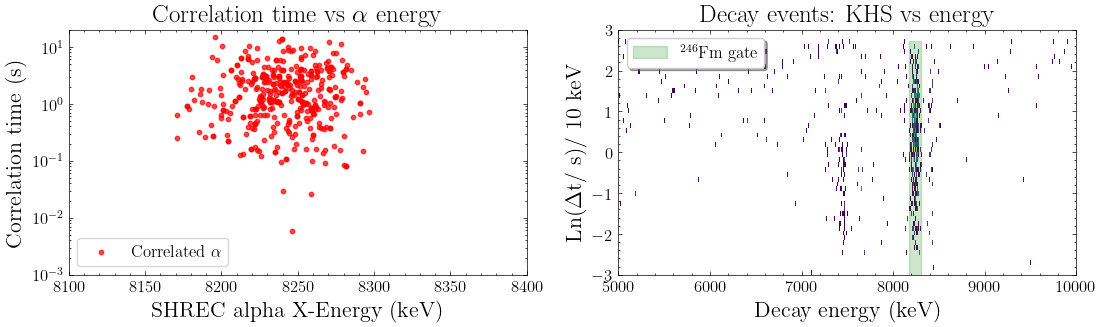

In [27]:
# # log decay time

final_correlated_df['log_dt'] = np.log10(np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t']))
final_correlated_df['rec_alpha_time'] =np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t'])
fs = 16
plt.figure(figsize=(13,7))

plt.subplot(221)
plt.scatter(final_correlated_df['alpha_xE'], final_correlated_df['rec_alpha_time'],
            s=10, color='red', alpha=0.7, label=r'Correlated $\alpha$')
plt.xlabel('SHREC alpha X-Energy (keV)', fontsize=fs)
# plt.ylabel(r'log(dt/s)', fontsize=fs)
plt.ylabel(r'Correlation time (s)', fontsize=fs)
plt.xlim(8100, 8400)
plt.yscale('log')
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4 )
plt.legend(fontsize=fs-4, loc='lower left', frameon=True)
plt.ylim(0.001,20)
plt.title(r'Correlation time vs $\alpha$ energy', fontsize=fs+2)

plt.subplot(222)
plt.hist2d(decay_candidates_df['xE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((5000,10000),(-3,3)), cmin=1)
plt.fill_betweenx(y=[np.log(alpha_corr_min), np.log(alpha_corr_max)], x1=alpha_energy_min, x2=alpha_energy_max, 
                  color='g', alpha=0.2, label=r'$^{246}$Fm gate')
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.legend(fontsize=fs-4, loc='upper left', frameon=True, facecolor='white', shadow=True)




# plt.savefig('plots/log_time_corr_alphas.pdf', dpi=300)

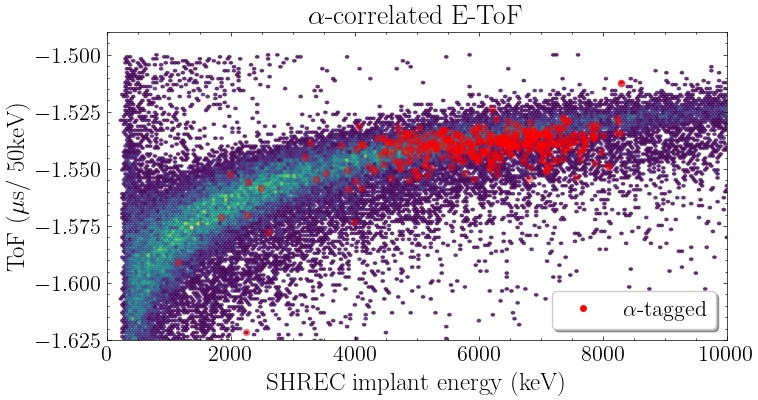

In [28]:
# # Correlated etof

plt.figure(figsize=(8,4))
fs = 18
plt.hexbin(coincident_imp_df['imp_xE'], coincident_imp_df['dt_anodeH_us_corr'], 
           gridsize=200, extent=(0, 10000, -1.7, -1.5), mincnt=1, cmap='viridis', alpha=0.7)
plt.scatter(final_correlated_df['rec_xE'], final_correlated_df['rec_dt_anodeH_us_corr'],
            color='red', alpha=0.4, s=20, label=r'$\alpha$-tagged')  
legend_marker = Line2D([0], [0], marker='o', color='w', markersize=6, 
                        markerfacecolor='red', label=r'$\alpha$-tagged')
plt.ylim(-1.625, -1.49)
plt.xlim(0, 10000)
plt.xlabel('SHREC implant energy (keV)', fontsize=fs)
plt.ylabel(r'ToF ($\mu$s/ 50keV)', fontsize=fs)
plt.title(r'$\alpha$-correlated E-ToF', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(handles=[legend_marker], loc='lower right', fontsize=fs-2, frameon=True, facecolor='white', shadow=True)
plt.savefig('plots/correlated_etof.pdf', dpi=300)

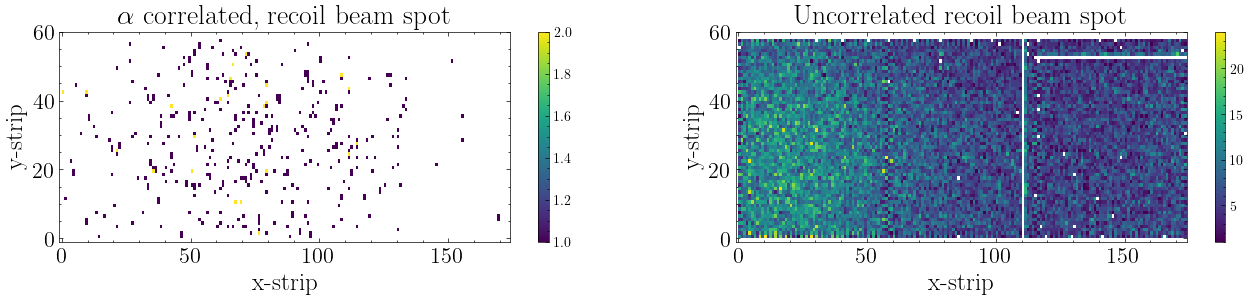

In [29]:
# # correlated beam spot
plt.figure(figsize=(16,6))
fs = 18
plt.subplot(221)
plt.hist2d(final_correlated_df['rec_x'], final_correlated_df['rec_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlim(0, 10000)
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'y-strip', fontsize=fs)
plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(loc='lower right', fontsize=fs-2, frameon=True)

plt.subplot(222)
plt.hist2d(coincident_imp_df['imp_x'], coincident_imp_df['imp_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlim(0, 10000)
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'y-strip', fontsize=fs)
plt.title(r'Uncorrelated recoil beam spot', fontsize=fs+2)
plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.savefig('plots/correlated_stripX_stripY.pdf', dpi=300)

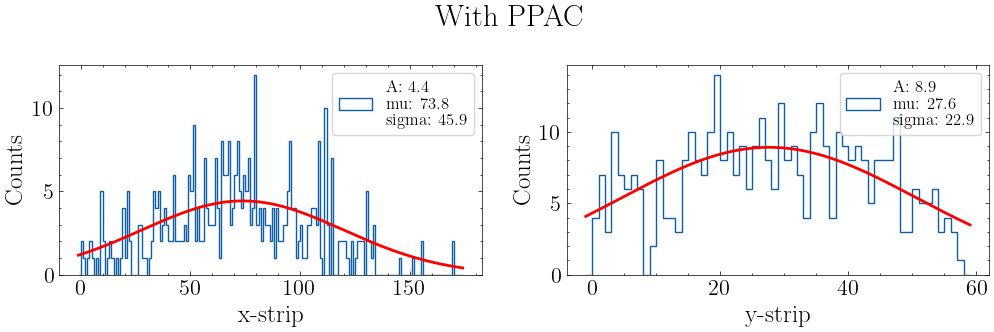

In [30]:
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2))


plt.figure(figsize=(12, 6))
fs = 18

# X projection 
plt.subplot(221)
hist_data_x, bin_edges_x, _ = plt.hist(final_correlated_df['rec_x'], histtype='step', 
                                      bins=175, range=(-1, 174))
bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2
mask_x = hist_data_x > 0
x_fit = bin_centers_x[mask_x]
y_fit = hist_data_x[mask_x]

p0_x = [np.max(y_fit), np.mean(final_correlated_df['rec_x']), np.std(final_correlated_df['rec_x'])]

try:

    popt_x, pcov_x = curve_fit(gaussian, x_fit, y_fit, p0=p0_x)
    

    x_curve = np.linspace(-1, 174, 1000)
    y_curve = gaussian(x_curve, *popt_x)
    plt.plot(x_curve, y_curve, 'r-', linewidth=2)
    plt.legend([f'A: {popt_x[0]:.1f}\nmu: {popt_x[1]:.1f}\nsigma: {popt_x[2]:.1f}'], 
              fontsize=fs-6, frameon=True)
except Exception as e:
    print(f"{e}")

plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

# Y projection 
plt.subplot(222)
hist_data_y, bin_edges_y, _ = plt.hist(final_correlated_df['rec_y'], histtype='step', 
                                      bins=60, range=(-1, 59))
bin_centers_y = (bin_edges_y[:-1] + bin_edges_y[1:]) / 2


mask_y = hist_data_y > 0
y_fit_x = bin_centers_y[mask_y]  
y_fit_y = hist_data_y[mask_y]    

p0_y = [np.max(y_fit_y), np.mean(final_correlated_df['rec_y']), np.std(final_correlated_df['rec_y'])]

try:
    popt_y, pcov_y = curve_fit(gaussian, y_fit_x, y_fit_y, p0=p0_y)
    y_curve_x = np.linspace(-1, 59, 1000)
    y_curve_y = gaussian(y_curve_x, *popt_y)
    plt.plot(y_curve_x, y_curve_y, 'r-', linewidth=2)
    plt.legend([f'A: {popt_y[0]:.1f}\nmu: {popt_y[1]:.1f}\nsigma: {popt_y[2]:.1f}'], 
              fontsize=fs-6, frameon=True)
except Exception as e:
    print(f"{e}")

plt.suptitle('With PPAC', fontsize=fs+4, y=0.98)
plt.xlabel('y-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)


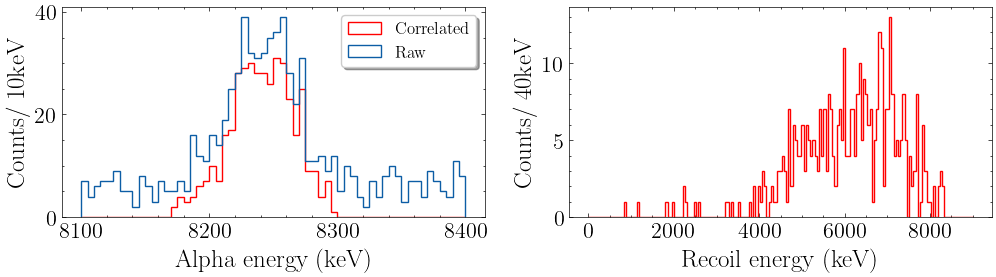

In [31]:
# Recoil and alpha energies

plt.figure(figsize=(12,6))
fs = 18

plt.subplot(221)
plt.hist(final_correlated_df['alpha_xE'], histtype='step', color='r', bins=60, range=(8100,8400), label='Correlated')
plt.hist(decay_candidates_df['xE'], histtype='step', bins=60, range=(8100,8400), label='Raw')
plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-6, frameon=True, shadow=True)

plt.subplot(222)
plt.hist(final_correlated_df['rec_xE'], histtype='step',bins=175, range=(0,9000), color='r')
# plt.hist(coincident_imp_df['im\p_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 40keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# ax.set_xlim(2000,8000)


plt.savefig('plots/rec_alpha_energy_projections.pdf', dpi=300)

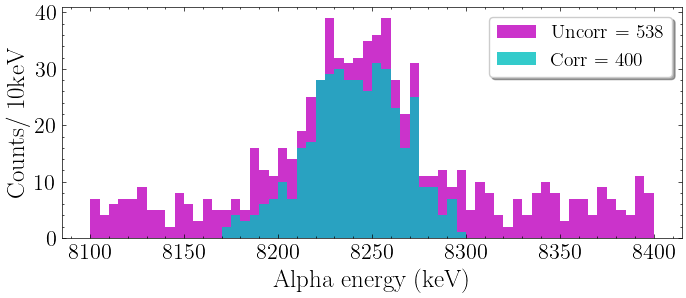

In [32]:
plt.figure(figsize=(8,3))
fs = 18
label_corr = f'Corr = {len(final_correlated_df)}'
len_uncorr_alphas = len(decay_candidates_df[
    (decay_candidates_df["xE"] >= alpha_energy_min) &
    (decay_candidates_df["xE"] <= alpha_energy_max)
]["xE"])
label_uncorr = f'Uncorr = {len_uncorr_alphas}'
plt.hist(decay_candidates_df['xE'], histtype='stepfilled', color='m',alpha=0.8, bins=60, range=(8100,8400), label=label_uncorr)
plt.hist(final_correlated_df['alpha_xE'], histtype='stepfilled', color='c', alpha=0.8, bins=60, range=(8100,8400), label=label_corr)
plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.savefig('plots/raw_vs_correlated_alphas.pdf', dpi=300)

In [33]:
# # Save the dfs
# coincident_imp_df.to_csv(f"{run_path}/coincident_imp.csv", index=False)
# final_correlated_df.to_csv(f"{run_path}/final_correlated.csv", index=False)
# decay_candidates_df.to_csv(f"{run_path}/decay_candidates.csv", index=False)
# non_coincident_imp_df.to_csv(f"{run_path}/non_coincident_imp.csv", index=False)

In [34]:
# calculate number of evr-a events per 1k rutherfords
n_evr_alpha = len(final_correlated_df)
n_rutherford = len(ruth_E_cut)  
evr_per_1k_ruth = (n_evr_alpha / n_rutherford) * 1000

print(f"EVR-alpha events: {n_evr_alpha}")
print(f"Rutherford events: {n_rutherford}")
print(f"EVR-alpha events per 1000 Rutherford events: {evr_per_1k_ruth:.2f}")

EVR-alpha events: 400
Rutherford events: 173844
EVR-alpha events per 1000 Rutherford events: 2.30


# Apha bkg subtraction

Peak region: 8172-8298 keV
Correlated counts in peak: 400
Uncorrelated counts in peak: 538
Background-subtracted counts in peak: 379.83333333333337
Ratio (corr/uncorr): 0.743
Ratio (corr/bkg-subtracted): 1.053


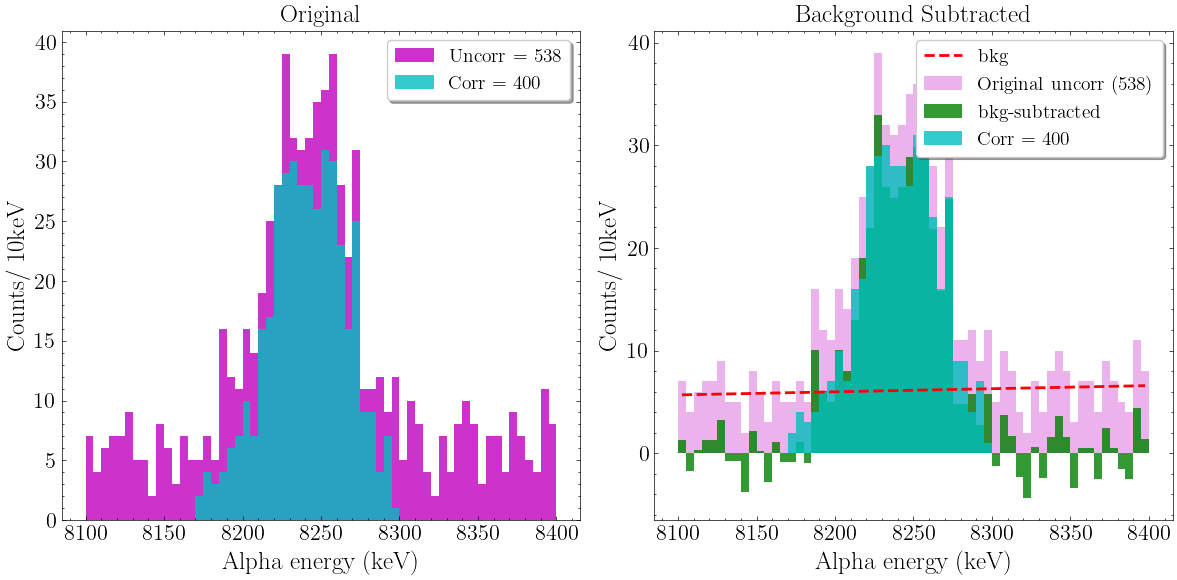

In [35]:

plt.figure(figsize=(12,6))
plt.subplot(121)
label_corr = f'Corr = {len(final_correlated_df)}'
len_uncorr_alphas = len(decay_candidates_df[
    (decay_candidates_df["xE"] >= alpha_energy_min) &
    (decay_candidates_df["xE"] <= alpha_energy_max)
]["xE"])
label_uncorr = f'Uncorr = {len_uncorr_alphas}'

hist_uncorr, bin_edges = np.histogram(
    decay_candidates_df['xE'], 
    bins=60, 
    range=(8100,8400)
)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.hist(decay_candidates_df['xE'], histtype='stepfilled', color='m', alpha=0.8, 
         bins=60, range=(8100,8400), label=label_uncorr)
plt.hist(final_correlated_df['alpha_xE'], histtype='stepfilled', color='c', alpha=0.8, 
         bins=60, range=(8100,8400), label=label_corr)

plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.title("Original", fontsize=fs)

###########################################################
# Bkg sub plot 
plt.subplot(122)

# Ddefine bkg regions
bkg_region1 = (8100, 8170)  
bkg_region2 = (8350, 8400)  

# get bkg points & use mask
bkg_mask = ((bin_centres >= bkg_region1[0]) & (bin_centres <= bkg_region1[1])) | \
           ((bin_centres >= bkg_region2[0]) & (bin_centres <= bkg_region2[1]))
bkg_x = bin_centres[bkg_mask]
bkg_y = hist_uncorr[bkg_mask]

# linear background
m, c, r_value, p_value, std_err = stats.linregress(bkg_x, bkg_y)
background = m * bin_centres + c
background = np.maximum(background, 0)

# bkg sub
hist_subtracted = hist_uncorr - background

plt.bar(bin_centres, hist_uncorr, width=5, alpha=0.3, color='m', 
        label=f'Original uncorr ({len_uncorr_alphas})')

plt.plot(bin_centres, background, 'r--', lw=2, label='bkg')

plt.bar(bin_centres, hist_subtracted, width=5, alpha=0.8, color='g', 
        label='bkg-subtracted')

hist_corr, _ = np.histogram(final_correlated_df['alpha_xE'], bins=60, range=(8100,8400))
plt.bar(bin_centres, hist_corr, width=5, alpha=0.8, color='c', 
        label=label_corr)

plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(fontsize=fs-4, frameon=True, shadow=True)
plt.title("Background Subtracted", fontsize=fs)

peak_min_idx = np.searchsorted(bin_centres, alpha_energy_min)  # Find bin index for min alpha 
peak_max_idx = np.searchsorted(bin_centres, alpha_energy_max)  # Find bin index for max alpha

# Calculate the ratio in the peak region
corr_peak_sum = np.sum(hist_corr[peak_min_idx:peak_max_idx])
uncorr_peak_sum = np.sum(hist_uncorr[peak_min_idx:peak_max_idx])
bkg_subtracted_sum = np.sum(hist_subtracted[peak_min_idx:peak_max_idx])

print(f'Peak region: {bin_centres[peak_min_idx]:.0f}-{bin_centres[peak_max_idx-1]:.0f} keV')
print(f'Correlated counts in peak: {corr_peak_sum}')
print(f'Uncorrelated counts in peak: {uncorr_peak_sum}')
print(f'Background-subtracted counts in peak: {bkg_subtracted_sum}')
print(f'Ratio (corr/uncorr): {corr_peak_sum/uncorr_peak_sum:.3f}')
print(f'Ratio (corr/bkg-subtracted): {corr_peak_sum/bkg_subtracted_sum:.3f}')
plt.tight_layout()
plt.savefig('plots/background_subtracted_alphas.pdf', dpi=300)

# Fit KHS funciton for half-life

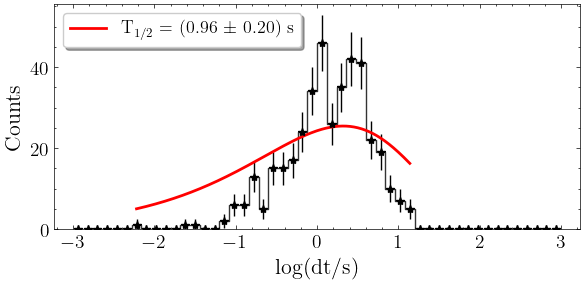

In [37]:
def khs_function(theta, l, n0):
    return n0 * np.exp(theta + np.log(l)) * np.exp(-np.exp(theta + np.log(l)))


bins = 50
hist_range = (-3, 3)
hist, bin_edges = np.histogram(final_correlated_df['log_dt'], bins=bins, range=hist_range)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 

# only on non-zero bins
nonzero_mask = hist > 0
fit_bin_centres = bin_centres[nonzero_mask]
# fit_bin_centres = bin_centres
fit_hist = hist[nonzero_mask]
# fit_hist = hist


T_half_guess = 1.52  # seconds 
lambda_guess = np.log(2) / T_half_guess
n0_guess = np.max(fit_hist)  
initial_guess = [lambda_guess, n0_guess]


popt, pcov = curve_fit(khs_function, fit_bin_centres, fit_hist, p0=initial_guess)

l_fit, n0_fit = popt
l_fit_err, n0_fit_err = np.sqrt(np.diag(pcov))

t_half = np.log(2) / l_fit
t_half_err = (np.log(2) / l_fit**2) * l_fit_err

theta_fit = np.linspace(fit_bin_centres.min(), fit_bin_centres.max(), 500)
fit_curve = khs_function(theta_fit, *popt)

fs=20
plt.figure(figsize=(6, 3))
plt.errorbar(bin_centres, hist, yerr=(hist+1)**0.5, fmt='k*')
# plt.hist(final_correlated_df['log_dt'], bins=bins, range=hist_range, histtype='stepfilled', alpha=0.8)
plt.step(bin_centres, hist, where='mid', alpha=0.8, color='k')
plt.plot(theta_fit, fit_curve, 'r-', linewidth=2, label=r'T$_{{1/2}}$ = ({:.2f} $\pm$ {:.2f}) s'.format(t_half, t_half_err))
plt.xlabel('log(dt/s)', fontsize=fs-4)
plt.ylabel('Counts',  fontsize=fs-4)
plt.legend(fontsize=fs-7, frameon=True, shadow=True, facecolor='White', loc='upper left')
# plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.tick_params(labelsize = fs-6)
plt.ylim(bottom=0)
plt.show()
